
--- Starting Exploratory Data Analysis ---


C:\Users\nidak\AppData\Local\Temp\ipykernel_6984\1785498434.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=df, palette='PiYG')


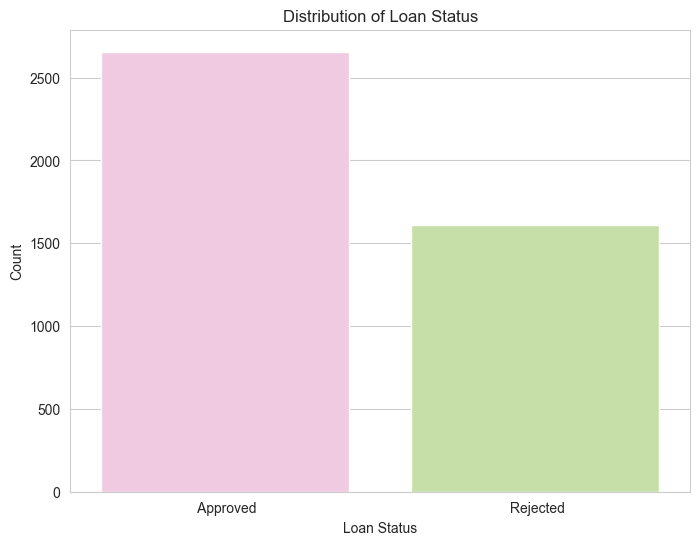

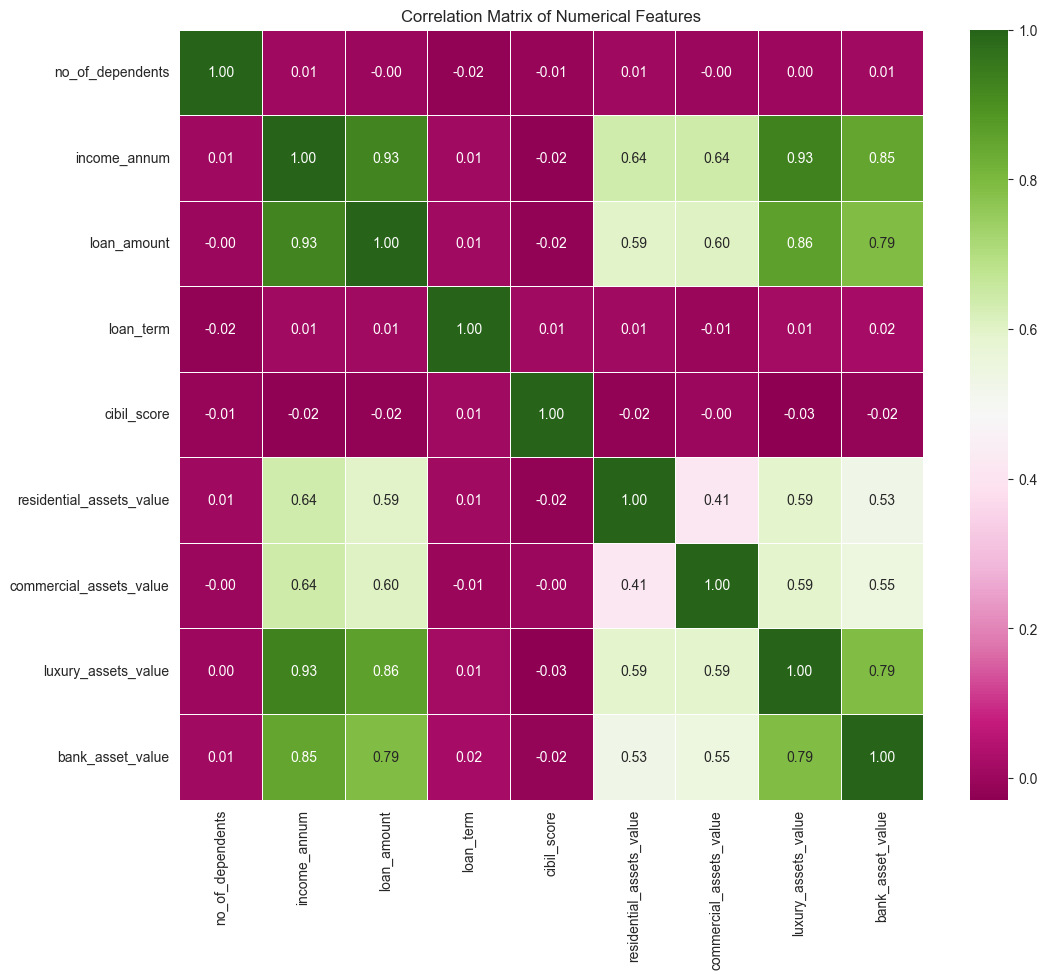

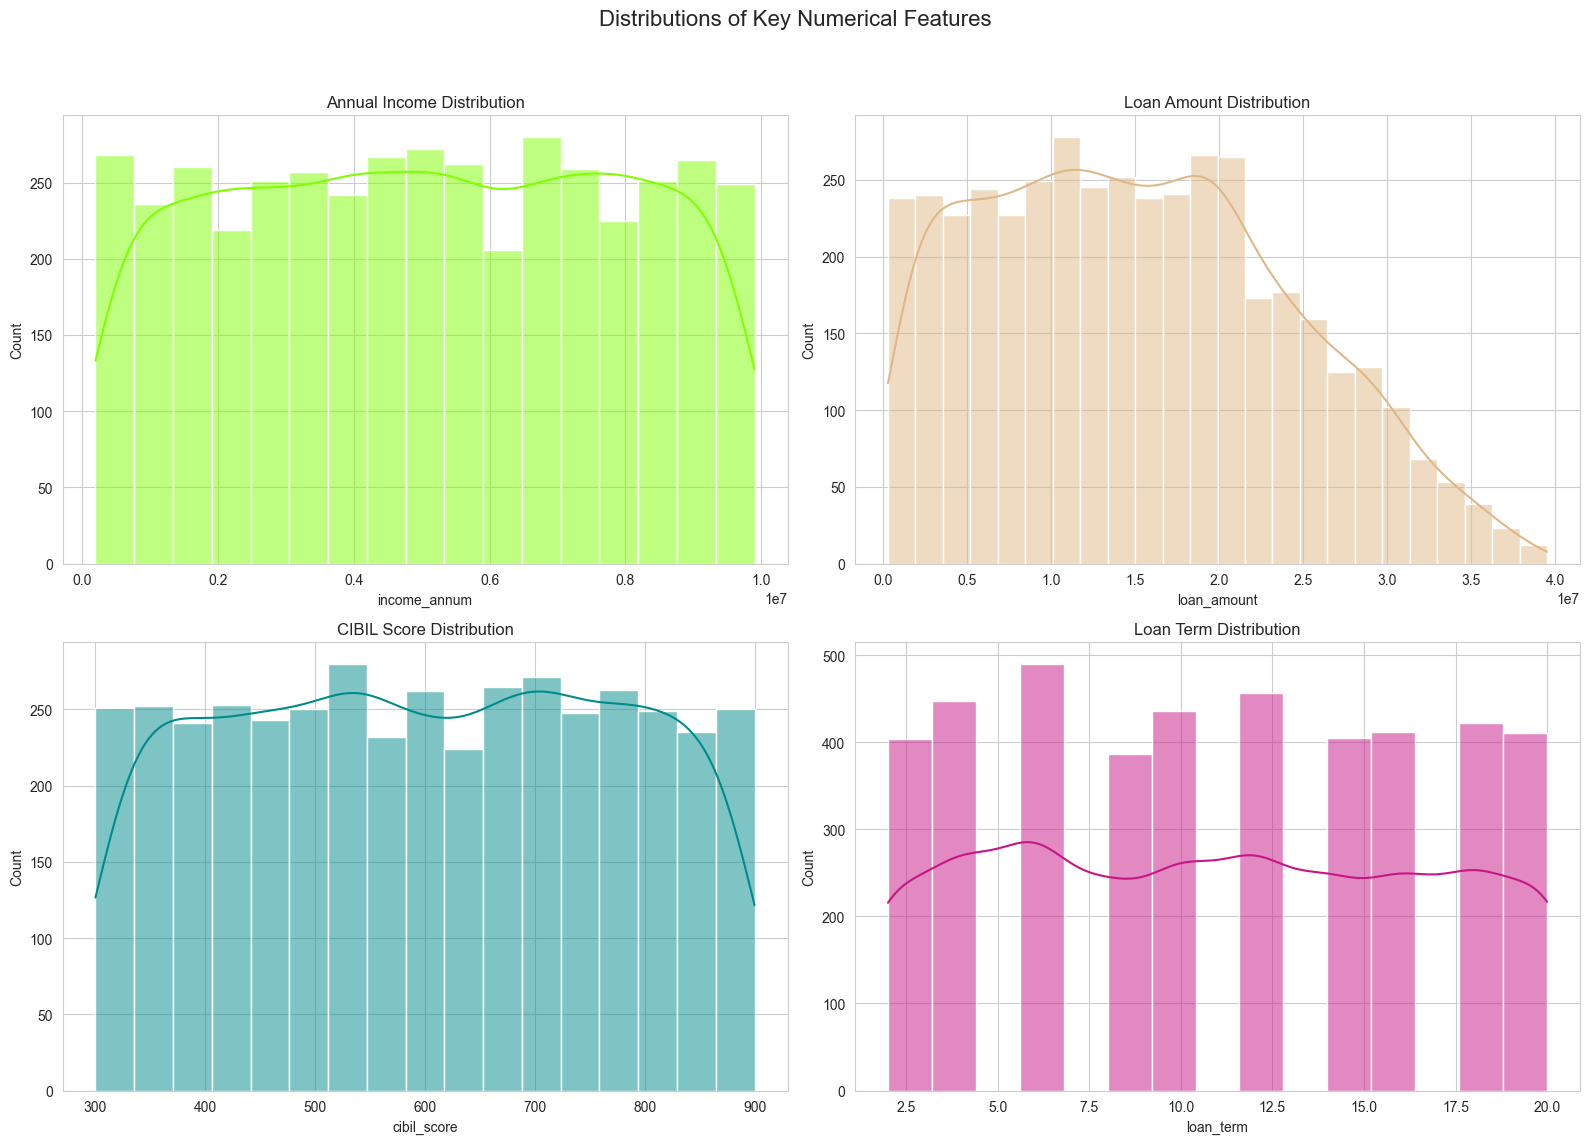

Numerical features: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Categorical features: ['education', 'self_employed']

Starting GridSearchCV... This may take a few minutes.
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV finished.

Best parameters found: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best ROC AUC score from cross-validation: 0.9976

--- Test Set Evaluation ---
ROC AUC Score: 0.9981


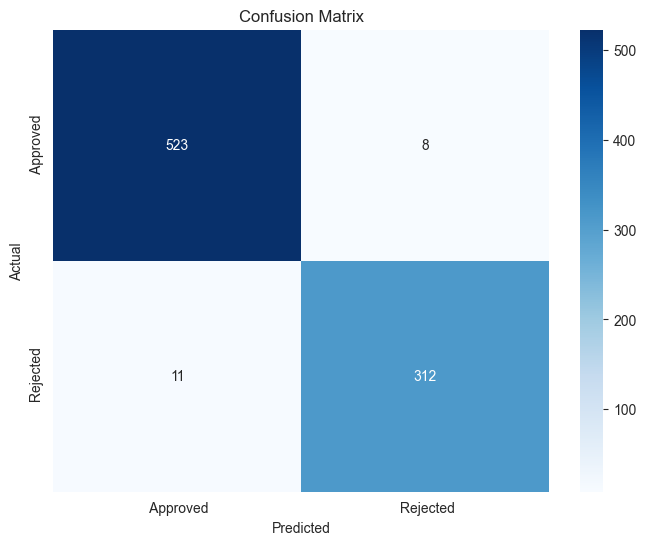


Classification Report:
              precision    recall  f1-score   support

    Approved       0.98      0.98      0.98       531
    Rejected       0.97      0.97      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



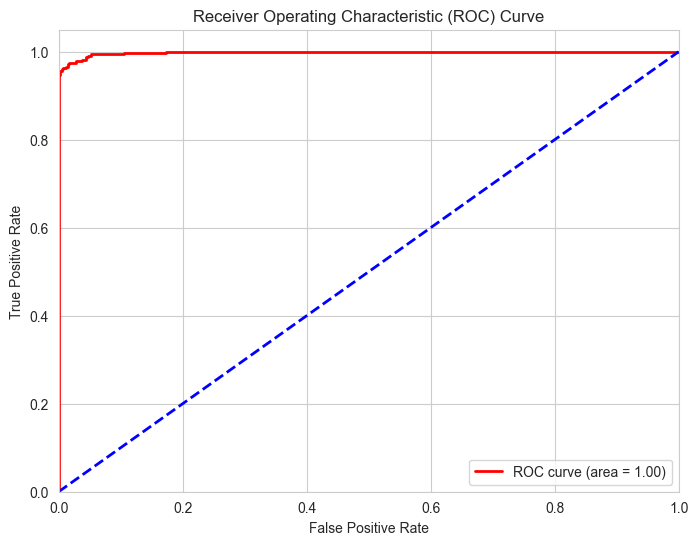

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
# The key change is to import Pipeline from imblearn, not sklearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# --- 1. Load and Inspect Data ---
try:
    # Load the dataset from the uploaded file
    df = pd.read_csv('D:/cohort/Machine Learning/Dataset/loan_approval_dataset.csv')
except FileNotFoundError:
    print("Error: 'loan_approval_dataset.csv' not found. Please ensure the file is in the correct directory.")
    # As a fallback for demonstration, create a dummy dataframe
    data = {'loan_id': range(100), ' no_of_dependents': np.random.randint(0, 5, 100),
            ' education': ['Graduate', 'Not Graduate']*50, ' self_employed': ['Yes', 'No']*50,
            ' income_annum': np.random.randint(20000, 1000000, 100), ' loan_amount': np.random.randint(50000, 500000, 100),
            ' loan_term': np.random.choice([12, 24, 36, 48], 100), ' cibil_score': np.random.randint(300, 900, 100),
            ' residential_assets_value': np.random.randint(0, 1000000, 100), ' commercial_assets_value': np.random.randint(0, 1000000, 100),
            ' luxury_assets_value': np.random.randint(0, 1000000, 100), ' bank_asset_value': np.random.randint(0, 1000000, 100),
            ' loan_status': ['Approved', 'Rejected']*50}
    df = pd.DataFrame(data)
    print("Using a dummy dataframe for demonstration.")


# --- 2. Data Cleaning and Preprocessing ---

# Clean up column names by removing leading/trailing spaces
df.columns = df.columns.str.strip()

# Drop the 'loan_id' as it's just an identifier and not a predictive feature
if 'loan_id' in df.columns:
    df = df.drop('loan_id', axis=1)

# --- 2.5 Exploratory Data Analysis (EDA) with Visualizations ---

print("\n--- Starting Exploratory Data Analysis ---")

# Set plot style
sns.set_style('whitegrid')

# Visualize the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='loan_status', data=df, palette='PiYG')
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

# Visualize the correlation matrix of numerical features
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='PiYG', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Visualize distributions of key numerical features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distributions of Key Numerical Features', fontsize=16)
sns.histplot(df['income_annum'], kde=True, ax=axes[0, 0], color='Chartreuse')
axes[0, 0].set_title('Annual Income Distribution')
sns.histplot(df['loan_amount'], kde=True, ax=axes[0, 1], color='BurlyWood')
axes[0, 1].set_title('Loan Amount Distribution')
sns.histplot(df['cibil_score'], kde=True, ax=axes[1, 0], color='DarkCyan')
axes[1, 0].set_title('CIBIL Score Distribution')
sns.histplot(df['loan_term'], kde=True, ax=axes[1, 1], color='MediumVioletRed')
axes[1, 1].set_title('Loan Term Distribution')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Encode the target variable 'loan_status' to numeric form (0 and 1)
le = LabelEncoder()
df['loan_status'] = le.fit_transform(df['loan_status'])

# Separate features (X) from the target variable (y)
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Identify which columns are numeric and which are categorical
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# --- 3. Create Preprocessing Pipelines ---

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# --- 4. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- 5. Build the Full Pipeline with SMOTE and Classifier ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])


# --- 6. Hyperparameter Tuning with GridSearchCV ---
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5,
                           scoring='roc_auc', n_jobs=-1, verbose=1)

print("\nStarting GridSearchCV... This may take a few minutes.")
grid_search.fit(X_train, y_train)
print("GridSearchCV finished.")

# --- 7. Evaluate the Best Model ---
best_model = grid_search.best_estimator_

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best ROC AUC score from cross-validation: {grid_search.best_score_:.4f}")

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Print and Visualize evaluation metrics
print("\n--- Test Set Evaluation ---")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Visualize ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='Red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='Blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
